In [1]:
import numpy as np
import tensorflow as tf
import random
from constants import TASK_LIST
from constants import INITIAL_ALPHA
from constants import INITIAL_GAMMA
from constants import EPSILON
from constants import NUM_TRA_EPISODES_DQN
from constants import NUM_EVAL_EPISODES
from scene_loader import THORDiscreteEnvironment as Environment


np.random.seed(1)
tf.set_random_seed(1)


# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(self.s_, w1) + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            #print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]

        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]

        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylim(0,10)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()





In [2]:
def evaluate(compare_list, env, RL):
    reward_list = []
    episodelength_list = []
    collision_list = []
    for i in range(NUM_EVAL_EPISODES):
        env.reset()
        current_state = env.current_state_id
        observation = env.h5_file['resnet_feature'][current_state][0]
        episode_reward = 0
        episode_length = 0
        episode_collision = 0

        while env.terminal==False:
            action = RL.choose_action(observation)
            env.step(action)
            observation_ =  env.h5_file['resnet_feature'][env.current_state_id][0]
            if env.terminal == True:
                R = 10
            elif env.collided == True:
                R = -0.1
                episode_collision += 1
            else: 
                R = -0.01
            episode_reward += R
            episode_length += 1
            observation = observation_
        reward_list.append(episode_reward)
        episodelength_list.append(episode_length)
        collision_list.append(episode_collision)
    compare_list.append([reward_list, episodelength_list, collision_list])
    #print ("episodes: ", i)

In [3]:
list_of_tasks = TASK_LIST
scene_scopes = list_of_tasks.keys()


branches = []
for scene in scene_scopes:
    for task in list_of_tasks[scene]:
        branches.append((scene, task))

scene, task = branches[0]


env = Environment({
    'scene_name': scene,
    'terminal_state_id': int(task)
})
env.reset()


RL = DeepQNetwork(env.nA, 2048,
                      learning_rate=0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=2000,
                      # output_graph=True
                      )


step = 0
compare_list=[]
for i in range(2000):
    # initial observation
    env.reset()
    current_state = env.current_state_id
    observation = env.h5_file['resnet_feature'][current_state][0]
    
    episode_reward = 0
    episode_length = 0
        
    while env.terminal==False and episode_length<10000:

        # RL choose action based on observation
        action = RL.choose_action(observation)
        # RL take action and get next observation and reward
        
        env.step(action)
        observation_ =  env.h5_file['resnet_feature'][env.current_state_id][0]
        if env.terminal == True:
            R = 10
        elif env.collided == True:
            R = -0.1
        else: R = -0.01
        episode_length += 1
        episode_reward += R
        RL.store_transition(observation, action, R, observation_)

        if (step > 200) and (step % 5 == 0):
            RL.learn()

        # swap observation
        observation = observation_
        step += 1
    
    print ("episodes: ", i)
    print ("current id: ", env.current_state_id)
    print ("episode reward: ", episode_reward)
    print ("episode length: ", episode_length)
    if (i+1) % 200 == 0:
        evaluate(compare_list, env, RL)
#RL.plot_cost()

episodes:  0
current id:  26
episode reward:  -72.68000000000087
episode length:  2815
episodes:  1
current id:  26
episode reward:  -69.72000000000017
episode length:  1943
episodes:  2
current id:  26
episode reward:  8.6
episode length:  33
episodes:  3
current id:  26
episode reward:  2.4500000000000144
episode length:  117
episodes:  4
current id:  26
episode reward:  6.330000000000002
episode length:  107
episodes:  5
current id:  26
episode reward:  -4.559999999999938
episode length:  332
episodes:  6
current id:  26
episode reward:  -67.77000000000118
episode length:  2036
episodes:  7
current id:  26
episode reward:  3.9700000000000193
episode length:  199
episodes:  8
current id:  26
episode reward:  -112.68000000000269
episode length:  3485
episodes:  9
current id:  26
episode reward:  -33.32000000000036
episode length:  1048
episodes:  10
current id:  26
episode reward:  -50.629999999999455
episode length:  2122
episodes:  11
current id:  26
episode reward:  2.7700000000000

episodes:  98
current id:  26
episode reward:  0.6400000000000698
episode length:  379
episodes:  99
current id:  26
episode reward:  8.079999999999998
episode length:  175
episodes:  100
current id:  26
episode reward:  0.500000000000135
episode length:  816
episodes:  101
current id:  26
episode reward:  -5.129999999999862
episode length:  758
episodes:  102
current id:  26
episode reward:  8.389999999999999
episode length:  144
episodes:  103
current id:  26
episode reward:  0.030000000000123705
episode length:  755
episodes:  104
current id:  26
episode reward:  2.920000000000103
episode length:  682
episodes:  105
current id:  26
episode reward:  9.97
episode length:  4
episodes:  106
current id:  26
episode reward:  -10.900000000000382
episode length:  1722
episodes:  107
current id:  26
episode reward:  -13.010000000000382
episode length:  1636
episodes:  108
current id:  26
episode reward:  -18.590000000001567
episode length:  2500
episodes:  109
current id:  26
episode reward:

episodes:  195
current id:  26
episode reward:  9.17
episode length:  84
episodes:  196
current id:  26
episode reward:  5.740000000000046
episode length:  418
episodes:  197
current id:  26
episode reward:  -37.939999999999365
episode length:  3409
episodes:  198
current id:  26
episode reward:  -65.9500000000016
episode length:  6336
episodes:  199
current id:  26
episode reward:  7.860000000000001
episode length:  188
episodes:  200
current id:  26
episode reward:  -2.4699999999998514
episode length:  753
episodes:  201
current id:  26
episode reward:  -7.099999999999902
episode length:  1396
episodes:  202
current id:  26
episode reward:  2.760000000000108
episode length:  689
episodes:  203
current id:  26
episode reward:  -19.770000000001644
episode length:  2420
episodes:  204
current id:  26
episode reward:  -12.810000000000773
episode length:  1769
episodes:  205
current id:  26
episode reward:  -17.830000000000098
episode length:  723
episodes:  206
current id:  26
episode re

episodes:  294
current id:  26
episode reward:  -31.90999999999979
episode length:  3535
episodes:  295
current id:  26
episode reward:  -61.83999999999969
episode length:  5232
episodes:  296
current id:  26
episode reward:  9.97
episode length:  4
episodes:  297
current id:  26
episode reward:  3.5500000000000096
episode length:  169
episodes:  298
current id:  26
episode reward:  -19.340000000001563
episode length:  1585
episodes:  299
current id:  26
episode reward:  -1.1699999999998116
episode length:  1091
episodes:  300
current id:  26
episode reward:  -10.91000000000037
episode length:  1363
episodes:  301
current id:  26
episode reward:  4.360000000000063
episode length:  511
episodes:  302
current id:  26
episode reward:  -3.2599999999997724
episode length:  1264
episodes:  303
current id:  26
episode reward:  -8.729999999999972
episode length:  425
episodes:  304
current id:  26
episode reward:  -35.64999999999983
episode length:  2811
episodes:  305
current id:  26
episode 

episodes:  391
current id:  26
episode reward:  -9.540000000000315
episode length:  1406
episodes:  392
current id:  26
episode reward:  -36.48999999999921
episode length:  3876
episodes:  393
current id:  26
episode reward:  9.99
episode length:  2
episodes:  394
current id:  26
episode reward:  -6.349999999999813
episode length:  1312
episodes:  395
current id:  26
episode reward:  8.229999999999999
episode length:  160
episodes:  396
current id:  26
episode reward:  9.53
episode length:  48
episodes:  397
current id:  26
episode reward:  5.3300000000000445
episode length:  360
episodes:  398
current id:  26
episode reward:  0.5700000000001513
episode length:  908
episodes:  399
current id:  26
episode reward:  -5.059999999999777
episode length:  1246
episodes:  400
current id:  26
episode reward:  -43.94999999999829
episode length:  4127
episodes:  401
current id:  26
episode reward:  8.549999999999999
episode length:  101
episodes:  402
current id:  26
episode reward:  0.7900000000

episodes:  487
current id:  26
episode reward:  7.170000000000014
episode length:  266
episodes:  488
current id:  26
episode reward:  -3.559999999999823
episode length:  997
episodes:  489
current id:  26
episode reward:  5.660000000000046
episode length:  381
episodes:  490
current id:  26
episode reward:  5.420000000000049
episode length:  441
episodes:  491
current id:  26
episode reward:  7.120000000000015
episode length:  280
episodes:  492
current id:  26
episode reward:  3.160000000000072
episode length:  505
episodes:  493
current id:  26
episode reward:  -6.309999999999789
episode length:  1389
episodes:  494
current id:  26
episode reward:  4.310000000000057
episode length:  372
episodes:  495
current id:  26
episode reward:  -17.740000000001473
episode length:  2172
episodes:  496
current id:  26
episode reward:  -3.7399999999998617
episode length:  709
episodes:  497
current id:  26
episode reward:  -8.350000000000101
episode length:  1548
episodes:  498
current id:  26
ep

episodes:  585
current id:  26
episode reward:  -1.3099999999999632
episode length:  205
episodes:  586
current id:  26
episode reward:  6.140000000000015
episode length:  225
episodes:  587
current id:  26
episode reward:  10
episode length:  1
episodes:  588
current id:  26
episode reward:  3.690000000000074
episode length:  542
episodes:  589
current id:  26
episode reward:  9.95
episode length:  6
episodes:  590
current id:  26
episode reward:  5.050000000000049
episode length:  433
episodes:  591
current id:  26
episode reward:  3.8600000000000847
episode length:  588
episodes:  592
current id:  26
episode reward:  8.329999999999998
episode length:  168
episodes:  593
current id:  26
episode reward:  9.059999999999999
episode length:  68
episodes:  594
current id:  26
episode reward:  -0.4199999999999555
episode length:  233
episodes:  595
current id:  26
episode reward:  6.450000000000028
episode length:  329
episodes:  596
current id:  26
episode reward:  -11.900000000000102
epi

episodes:  685
current id:  26
episode reward:  -18.370000000001323
episode length:  2523
episodes:  686
current id:  26
episode reward:  3.910000000000065
episode length:  340
episodes:  687
current id:  26
episode reward:  -1.7999999999998053
episode length:  1118
episodes:  688
current id:  26
episode reward:  9.07
episode length:  94
episodes:  689
current id:  26
episode reward:  4.040000000000013
episode length:  111
episodes:  690
current id:  26
episode reward:  9.99
episode length:  2
episodes:  691
current id:  26
episode reward:  7.45000000000001
episode length:  256
episodes:  692
current id:  26
episode reward:  5.440000000000047
episode length:  295
episodes:  693
current id:  26
episode reward:  8.099999999999998
episode length:  182
episodes:  694
current id:  26
episode reward:  9.92
episode length:  9
episodes:  695
current id:  26
episode reward:  -1.1099999999999
episode length:  590
episodes:  696
current id:  26
episode reward:  2.890000000000093
episode length:  

episodes:  785
current id:  26
episode reward:  0.06000000000013905
episode length:  842
episodes:  786
current id:  26
episode reward:  8.78
episode length:  105
episodes:  787
current id:  26
episode reward:  -7.079999999999906
episode length:  1187
episodes:  788
current id:  26
episode reward:  -15.02000000000075
episode length:  2053
episodes:  789
current id:  26
episode reward:  -18.820000000000917
episode length:  1200
episodes:  790
current id:  26
episode reward:  8.28
episode length:  155
episodes:  791
current id:  26
episode reward:  9.16
episode length:  85
episodes:  792
current id:  26
episode reward:  3.7600000000000717
episode length:  508
episodes:  793
current id:  26
episode reward:  7.390000000000011
episode length:  253
episodes:  794
current id:  26
episode reward:  9.309999999999999
episode length:  70
episodes:  795
current id:  26
episode reward:  7.959999999999999
episode length:  196
episodes:  796
current id:  26
episode reward:  6.210000000000033
episode 

episodes:  886
current id:  26
episode reward:  -21.920000000000773
episode length:  1627
episodes:  887
current id:  26
episode reward:  -15.700000000000351
episode length:  753
episodes:  888
current id:  26
episode reward:  1.8200000000001264
episode length:  792
episodes:  889
current id:  26
episode reward:  -14.100000000000673
episode length:  1781
episodes:  890
current id:  26
episode reward:  9.97
episode length:  4
episodes:  891
current id:  26
episode reward:  -3.4499999999998856
episode length:  644
episodes:  892
current id:  26
episode reward:  8.139999999999999
episode length:  187
episodes:  893
current id:  26
episode reward:  4.940000000000019
episode length:  291
episodes:  894
current id:  26
episode reward:  -20.370000000000836
episode length:  1931
episodes:  895
current id:  26
episode reward:  -18.750000000001407
episode length:  2273
episodes:  896
current id:  26
episode reward:  -1.5999999999998114
episode length:  1089
episodes:  897
current id:  26
episode

episodes:  985
current id:  26
episode reward:  -2.1099999999998076
episode length:  1086
episodes:  986
current id:  26
episode reward:  9.92
episode length:  9
episodes:  987
current id:  26
episode reward:  2.8200000000000287
episode length:  224
episodes:  988
current id:  26
episode reward:  9.94
episode length:  7
episodes:  989
current id:  26
episode reward:  8.639999999999999
episode length:  137
episodes:  990
current id:  26
episode reward:  7.110000000000015
episode length:  254
episodes:  991
current id:  26
episode reward:  9.19
episode length:  73
episodes:  992
current id:  26
episode reward:  5.15000000000004
episode length:  378
episodes:  993
current id:  26
episode reward:  3.050000000000094
episode length:  633
episodes:  994
current id:  26
episode reward:  -23.360000000001747
episode length:  3040
episodes:  995
current id:  26
episode reward:  -14.880000000000926
episode length:  1526
episodes:  996
current id:  26
episode reward:  7.380000000000011
episode leng

episodes:  1085
current id:  26
episode reward:  -4.579999999999767
episode length:  1270
episodes:  1086
current id:  26
episode reward:  9.81
episode length:  20
episodes:  1087
current id:  26
episode reward:  -3.4699999999998212
episode length:  979
episodes:  1088
current id:  26
episode reward:  2.790000000000095
episode length:  641
episodes:  1089
current id:  26
episode reward:  9.93
episode length:  8
episodes:  1090
current id:  26
episode reward:  9.99
episode length:  2
episodes:  1091
current id:  26
episode reward:  0.5900000000001153
episode length:  717
episodes:  1092
current id:  26
episode reward:  9.96
episode length:  5
episodes:  1093
current id:  26
episode reward:  9.74
episode length:  27
episodes:  1094
current id:  26
episode reward:  -0.09999999999985043
episode length:  867
episodes:  1095
current id:  26
episode reward:  -5.799999999999782
episode length:  1203
episodes:  1096
current id:  26
episode reward:  -10.14000000000038
episode length:  1502
episo

episodes:  1185
current id:  26
episode reward:  4.120000000000075
episode length:  508
episodes:  1186
current id:  26
episode reward:  9.43
episode length:  58
episodes:  1187
current id:  26
episode reward:  -19.08000000000149
episode length:  2216
episodes:  1188
current id:  26
episode reward:  5.270000000000051
episode length:  447
episodes:  1189
current id:  26
episode reward:  -7.980000000000111
episode length:  1331
episodes:  1190
current id:  26
episode reward:  9.94
episode length:  7
episodes:  1191
current id:  26
episode reward:  8.739999999999998
episode length:  127
episodes:  1192
current id:  26
episode reward:  4.820000000000029
episode length:  321
episodes:  1193
current id:  26
episode reward:  9.97
episode length:  4
episodes:  1194
current id:  26
episode reward:  -0.31999999999992745
episode length:  421
episodes:  1195
current id:  26
episode reward:  -2.2999999999998977
episode length:  565
episodes:  1196
current id:  26
episode reward:  9.61
episode lengt

episodes:  1284
current id:  26
episode reward:  -22.300000000001447
episode length:  2367
episodes:  1285
current id:  26
episode reward:  -14.73000000000069
episode length:  2015
episodes:  1286
current id:  26
episode reward:  4.080000000000037
episode length:  332
episodes:  1287
current id:  26
episode reward:  9.52
episode length:  49
episodes:  1288
current id:  26
episode reward:  1.9400000000001025
episode length:  663
episodes:  1289
current id:  26
episode reward:  -0.6199999999998465
episode length:  928
episodes:  1290
current id:  26
episode reward:  5.810000000000035
episode length:  213
episodes:  1291
current id:  26
episode reward:  9.129999999999999
episode length:  88
episodes:  1292
current id:  26
episode reward:  -13.230000000000803
episode length:  1919
episodes:  1293
current id:  26
episode reward:  8.02
episode length:  163
episodes:  1294
current id:  26
episode reward:  -17.820000000001034
episode length:  1415
episodes:  1295
current id:  26
episode reward

episodes:  1383
current id:  26
episode reward:  9.94
episode length:  7
episodes:  1384
current id:  26
episode reward:  10
episode length:  1
episodes:  1385
current id:  26
episode reward:  1.1800000000000335
episode length:  343
episodes:  1386
current id:  26
episode reward:  9.08
episode length:  93
episodes:  1387
current id:  26
episode reward:  -18.350000000001025
episode length:  1918
episodes:  1388
current id:  26
episode reward:  0.19000000000013628
episode length:  811
episodes:  1389
current id:  26
episode reward:  9.95
episode length:  6
episodes:  1390
current id:  26
episode reward:  -0.46999999999987274
episode length:  823
episodes:  1391
current id:  26
episode reward:  9.92
episode length:  9
episodes:  1392
current id:  26
episode reward:  4.020000000000078
episode length:  563
episodes:  1393
current id:  26
episode reward:  8.469999999999999
episode length:  127
episodes:  1394
current id:  26
episode reward:  -6.899999999999881
episode length:  1511
episodes:

episodes:  1484
current id:  26
episode reward:  9.23
episode length:  69
episodes:  1485
current id:  26
episode reward:  9.98
episode length:  3
episodes:  1486
current id:  26
episode reward:  9.99
episode length:  2
episodes:  1487
current id:  26
episode reward:  -3.2499999999998064
episode length:  1074
episodes:  1488
current id:  26
episode reward:  8.78
episode length:  105
episodes:  1489
current id:  26
episode reward:  8.969999999999999
episode length:  104
episodes:  1490
current id:  26
episode reward:  7.4100000000000055
episode length:  179
episodes:  1491
current id:  26
episode reward:  9.8
episode length:  21
episodes:  1492
current id:  26
episode reward:  4.0500000000000655
episode length:  515
episodes:  1493
current id:  26
episode reward:  9.94
episode length:  7
episodes:  1494
current id:  26
episode reward:  5.610000000000045
episode length:  368
episodes:  1495
current id:  26
episode reward:  5.160000000000059
episode length:  458
episodes:  1496
current id

episodes:  1583
current id:  26
episode reward:  2.940000000000051
episode length:  410
episodes:  1584
current id:  26
episode reward:  9.92
episode length:  9
episodes:  1585
current id:  26
episode reward:  -4.729999999999775
episode length:  1267
episodes:  1586
current id:  26
episode reward:  3.020000000000092
episode length:  618
episodes:  1587
current id:  26
episode reward:  9.94
episode length:  7
episodes:  1588
current id:  26
episode reward:  6.870000000000022
episode length:  269
episodes:  1589
current id:  26
episode reward:  7.890000000000001
episode length:  212
episodes:  1590
current id:  26
episode reward:  9.5
episode length:  51
episodes:  1591
current id:  26
episode reward:  9.89
episode length:  12
episodes:  1592
current id:  26
episode reward:  5.900000000000037
episode length:  240
episodes:  1593
current id:  26
episode reward:  8.94
episode length:  98
episodes:  1594
current id:  26
episode reward:  -0.4099999999999202
episode length:  520
episodes:  15

episodes:  1680
current id:  26
episode reward:  1.080000000000128
episode length:  785
episodes:  1681
current id:  26
episode reward:  8.169999999999998
episode length:  112
episodes:  1682
current id:  26
episode reward:  -7.9000000000000945
episode length:  756
episodes:  1683
current id:  26
episode reward:  -11.990000000000716
episode length:  1408
episodes:  1684
current id:  26
episode reward:  9.96
episode length:  5
episodes:  1685
current id:  26
episode reward:  6.680000000000025
episode length:  279
episodes:  1686
current id:  26
episode reward:  -9.910000000000302
episode length:  1425
episodes:  1687
current id:  26
episode reward:  -2.829999999999785
episode length:  1212
episodes:  1688
current id:  26
episode reward:  -19.100000000001028
episode length:  1777
episodes:  1689
current id:  26
episode reward:  3.6000000000000085
episode length:  119
episodes:  1690
current id:  26
episode reward:  3.2000000000000917
episode length:  618
episodes:  1691
current id:  26
e

episodes:  1778
current id:  26
episode reward:  -15.030000000001031
episode length:  1874
episodes:  1779
current id:  26
episode reward:  9.72
episode length:  29
episodes:  1780
current id:  26
episode reward:  8.719999999999999
episode length:  129
episodes:  1781
current id:  26
episode reward:  3.7700000000000804
episode length:  561
episodes:  1782
current id:  26
episode reward:  -18.560000000000638
episode length:  1084
episodes:  1783
current id:  26
episode reward:  9.66
episode length:  35
episodes:  1784
current id:  26
episode reward:  3.3800000000000487
episode length:  276
episodes:  1785
current id:  26
episode reward:  9.18
episode length:  83
episodes:  1786
current id:  26
episode reward:  8.52
episode length:  140
episodes:  1787
current id:  26
episode reward:  9.95
episode length:  6
episodes:  1788
current id:  26
episode reward:  9.99
episode length:  2
episodes:  1789
current id:  26
episode reward:  9.73
episode length:  19
episodes:  1790
current id:  26
epi

episodes:  1878
current id:  26
episode reward:  4.180000000000048
episode length:  430
episodes:  1879
current id:  26
episode reward:  -8.530000000000104
episode length:  1458
episodes:  1880
current id:  26
episode reward:  2.7100000000000968
episode length:  604
episodes:  1881
current id:  26
episode reward:  9.03
episode length:  80
episodes:  1882
current id:  26
episode reward:  -10.500000000000508
episode length:  1376
episodes:  1883
current id:  26
episode reward:  9.08
episode length:  84
episodes:  1884
current id:  26
episode reward:  -2.0499999999998852
episode length:  702
episodes:  1885
current id:  26
episode reward:  9.69
episode length:  23
episodes:  1886
current id:  26
episode reward:  9.92
episode length:  9
episodes:  1887
current id:  26
episode reward:  8.79
episode length:  86
episodes:  1888
current id:  26
episode reward:  4.210000000000054
episode length:  418
episodes:  1889
current id:  26
episode reward:  -3.5399999999998286
episode length:  977
episo

episodes:  1977
current id:  26
episode reward:  0.8600000000001149
episode length:  699
episodes:  1978
current id:  26
episode reward:  7.270000000000014
episode length:  274
episodes:  1979
current id:  26
episode reward:  2.5200000000000404
episode length:  389
episodes:  1980
current id:  26
episode reward:  9.9
episode length:  11
episodes:  1981
current id:  26
episode reward:  0.6600000000001423
episode length:  827
episodes:  1982
current id:  26
episode reward:  2.1100000000000785
episode length:  565
episodes:  1983
current id:  26
episode reward:  3.1300000000000585
episode length:  436
episodes:  1984
current id:  26
episode reward:  -2.2999999999998124
episode length:  1078
episodes:  1985
current id:  26
episode reward:  6.110000000000037
episode length:  336
episodes:  1986
current id:  26
episode reward:  9.5
episode length:  51
episodes:  1987
current id:  26
episode reward:  7.1899999999999995
episode length:  183
episodes:  1988
current id:  26
episode reward:  -19.

In [4]:
RL.plot_cost()

<Figure size 640x480 with 1 Axes>

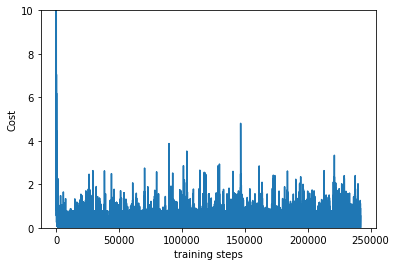

In [5]:
import matplotlib.pyplot as plt
plt.plot(RL.cost_his)
plt.ylim(0,10)
plt.ylabel('Cost')
plt.xlabel('training steps')
plt.show()


In [6]:
len(compare_list)

10

In [7]:
for i in range(10):
    print ("evaluate reward: ", np.mean(np.array(compare_list)[i][0]))

evaluate reward:  -3.3548000000001275
evaluate reward:  -5.294500000000201
evaluate reward:  5.501900000000046
evaluate reward:  6.063700000000017
evaluate reward:  4.829000000000005
evaluate reward:  4.685800000000009
evaluate reward:  4.739400000000022
evaluate reward:  4.859699999999994
evaluate reward:  6.2496999999999865
evaluate reward:  5.864000000000043
